# Code for computation of the STRIPES index for the diagnostics package

In [1]:
import xarray as xr
from STRIPES_utils import *
from fcst_utils import *
from obs_utils import *
import numpy as np
import glob
import gc
import proplot as plot

In [2]:
# inputs:
# path to z500 forecasts = Z500_DIR
# path to z500 observations = Z500_DIR_OBS
# path to precipitation forecasts = PREC_DIR
# path to precipitation observations = PREC_DIR_OBS
# full path to RMM file = RMM_FILE


'''
STRIPES OPTIONS
'''

compSTRIPES_z500 = True
compSTRIPES_prec = False



# file options
DIR_IN = '/ocean/projects/atm200007p/ajenney/ufs_data/'
Z500_DIR = DIR_IN + 'Prototype5/gh/*.nc'
Z500_DIR_OBS = DIR_IN + 'erai/z500/*.nc'
PREC_DIR = DIR_IN + 'Prototype5/prate/*.nc'
PREC_DIR_OBS = DIR_IN + 'IMERG/*.nc4'
RMM_FILE = DIR_IN + 'erai/rmm_ERA-Interim.nc'
# DIR_PLOT = 

# other options
START_DATE = '2011-01-01'
END_DATE = '2018-12-31'

# Regions to calculate averages for
reglons = np.asarray(((160,220), # north pacific
                      (270,340), # north atlantic
                      (348,28))) # europe
reglats = np.asarray(((30,55),   
                      (30,65),
                      (32,72)))
region_names=['North Pacific','North Atlantic','Europe']

In [3]:
# Function to calculate weighted mean over the region
def get_region_weighted_mean(reglats, reglons, dat):
    # Make sure "latitude" and "longitude" dimensions exist in the input data
    if "latitude" not in dat.dims or "longitude" not in dat.dims:
        raise ValueError("Input data must have 'latitude' and 'longitude' dimensions.")

    # Identify the spatial dimensions and their order
    lat_dim, lon_dim = dat.dims.index("latitude"), dat.dims.index("longitude")
    other_dims = [i for i in range(dat.ndim) if i not in (lat_dim, lon_dim)]

    # Create an empty array to hold the result of weighted mean for each region
    shape = (len(reglons),) + tuple(dat.shape[i] for i in other_dims)
    dat_region_weighted_mean = np.empty(shape)

    # Loop over each region
    for iregion in range(len(reglons)):
        # Find subset
        if np.diff(reglons[iregion]) < 0:
            lon = dat['longitude']
            ilon = (lon >= reglons[iregion, 0]) | (lon <= reglons[iregion, 1])
            subset = dat.sel(latitude=slice(reglats[iregion, 1], reglats[iregion, 0])).isel(longitude=ilon)
        else:
            subset = dat.sel(latitude=slice(reglats[iregion, 1], reglats[iregion, 0]),
                             longitude=slice(reglons[iregion, 0], reglons[iregion, 1]))

        # Take weighted average
        weights = np.cos(np.deg2rad(subset.latitude))
        dat_region_weighted_mean[iregion] = subset.weighted(weights).mean(('latitude','longitude'))

    # Create a DataArray to hold the result with the same dimensions as the input data
    dims = ["region"] + [dat.dims[i] for i in other_dims]
    coords = {"region": np.arange(len(reglons))}
    for dim in dims[1:]:
        coords[dim] = dat[dim]
    dat_region_weighted_mean = xr.DataArray(dat_region_weighted_mean, dims=dims, coords=coords)

    return dat_region_weighted_mean

In [4]:
def makeSTRIPESfigs(fc_dir, obs_dir, frmm, varname, t0, t1):
    '''
        Compute the STRIPES index and compare to observations

            Parameters
                fc_dir: directory where forecasts are located
                obs_dir: directory where observations are located
                frmm: rmm file containing phase and amplitude information
                varname: what the forecast variable is named in the files
                t0: START_DATE
                t1: END_DATE
            Returns


    '''
    # fc_dir = Z500_DIR
    # obs_dir = Z500_DIR_OBS
    # varname = 'gh'
    # frmm = RMM_FILE
    # t0 = START_DATE
    # t1 = END_DATE

    lags = [[0,13],
            [7,20],
            [14,27]]

    # -------- Open data --------
    rmm = xr.open_dataset(frmm)

    # forecast
    files = np.sort(glob.glob(fc_dir))
    fc = xr.open_mfdataset(files, combine='nested',
                           concat_dim='time',parallel='true')[varname]

    # obs
    if varname == 'gh':
        obs = xr.open_mfdataset(obs_dir).z/9.81
        obs.attrs['units']='m'
    if varname == 'prate':
        obs = xr.open_mfdataset(obs_dir).precipitationCAL
        fc = fc*86400 # mm/s to mm/day
    # subset time
    obs = obs.sel(time=slice(t0,t1))
    # make sure obs is organized time x lat x lon
    obs = obs.transpose('time','latitude','longitude')

    # -------- Calculate anomalies --------
    obs_anom=calcAnomObs(obs, varname)
    obs_anom.attrs['units']=obs.units
    del obs
    gc.collect()

    fc_anom = calcAnom(fc,varname)
    # Reshape 1D time dimension of UFS anomalies to 2D
    fc_anom = reshape_forecast(fc_anom, nfc=int(len(fc_anom.time)/len(files)))
    del fc
    gc.collect()

    # -------- Subset RMM and forecast data to winter --------
    rmm = rmm.sel(time=is_ndjfm(rmm['time.month']) & rmm.time.isin(fc_anom.time))
    fc_anom=fc_anom.sel(time=is_ndjfm(fc_anom['time.month']))

    # -------- Calculate STRIPES index --------
    stripes_obs = []
    stripes_fc = []
    for minlag, maxlag in lags:

        # ----- Obs -----
        lagcomp = calc_lagged_composite(obs_anom,
                                        rmm.amplitude > 1.0,
                                        rmm.phase.values, 
                                        maxlag = maxlag,
                                        minlag = minlag, 
                                        obs = True)
        stripes=compSTRIPES(lagcomp.values, [5,6,7,8])
        stripes_obs.append(xr.DataArray(stripes,
                                        attrs={'long_name': 'STRIPES', 
                                                'units': obs_anom.units},
                                        dims=['latitude','longitude'],
                                        coords={"latitude": obs_anom.latitude,
                                                "longitude": obs_anom.longitude}))
        del stripes
        del lagcomp

        # ----- Forecast -----
        lagcomp = calc_lagged_composite(fc_anom,
                                        rmm.amplitude > 1.0,
                                        rmm.phase.values, 
                                        maxlag = maxlag,
                                        minlag = minlag, 
                                        obs = False)
        stripes=compSTRIPES(lagcomp.values, [5,6,7,8])
        stripes=xr.DataArray(stripes, 
                             attrs={'long_name': 'STRIPES', 
                                    'units': obs_anom.units},
                             dims=['latitude','longitude'],
                             coords={"latitude": fc_anom.latitude,
                                     "longitude": fc_anom.longitude})
        # regrid if needed
        if not len(fc_anom.latitude)==len(obs_anom.latitude):
            stripes = regrid_scalar_spharm_AJ(stripes, 
                                              stripes.latitude,
                                              stripes.longitude,
                                              obs_anom.latitude,
                                              obs_anom.longitude)

        stripes_fc.append(stripes)
        del lagcomp
        del stripes
        gc.collect()

    # -------- Calculate regional mean values of the STRIPES index --------
    stripes_fc_region = []
    stripes_obs_region = []
    for ilag in range(len(lags)):
        stripes_fc_region.append(get_region_weighted_mean(reglats, reglons, stripes_fc[ilag])) 
        stripes_obs_region.append(get_region_weighted_mean(reglats, reglons, stripes_obs[ilag]))
    stripes_fc_region=xr.concat(stripes_fc_region,dim='lag')
    stripes_obs_region=xr.concat(stripes_obs_region,dim='lag')

    # Plot

    '''
    (1) Maps of the biases for weeks 1-2, 2-3, 3-4
    '''

    lags = ['1-2','2-3','3-4'] # in weeks

    lon = stripes_obs[0].longitude
    lat = stripes_obs[0].latitude

    if varname == 'gh':
        cmap_obs = 'Glacial'
        levs_obs = np.arange(0,110,10)
        levs_anom = np.arange(-25,30,5)
    elif varname == 'prate':
        cmap_obs = 'Boreal'
        levs_obs = np.arange(0,27.5,2.5)
        levs_anom = np.arange(-5, 6, 1)

    for ilag, lag in enumerate(lags):
        fig, ax = plot.subplots(nrows=len(lags), width=4.7, height=7,
                                proj='cyl',proj_kw={'lon_0': 260})
        ax.format(coast=True, latlines=30, lonlines=60,
                  lonlim=(-180,180),latlim=(-85,85),
                  lonlabels=(True,False),
                  latlabels=(True,False),abc=True)

        # Observations
        ax[0].contourf(lon,lat,stripes_obs[ilag],extend='max',
                       cmap=cmap_obs, colorbar='r', levels=levs_obs,
                       colorbar_kw={'length': 0.7,
                                    'label': ('STRIPES (' + 
                                              stripes_obs[0].units + ')')})
        ax[0].format(title='Obs., week ' + lag)

        # Forecast
        ax[1].contourf(lon,lat,stripes_fc[ilag],extend='max',
                       cmap=cmap_obs, colorbar='r', levels=levs_obs,
                       colorbar_kw={'length': 0.7,
                                    'label': ('STRIPES (' + 
                                              stripes_obs[0].units + ')')})
        ax[1].format(title='Forecast, week ' + lag)

        # Bias
        bias = stripes_fc[ilag] - stripes_obs[ilag]
        ax[2].contourf(lon,lat,bias,extend='both',
                       cmap='RdBu_r', colorbar='r', levels=levs_anom,
                       colorbar_kw={'length': 0.7,
                                    'label': ('STRIPES (' + 
                                              stripes_obs[0].units + ')')})
        ax[2].format(title='Forecast - Obs., week ' + lag)

    # save
    # fig.savefig(DIR_PLOT + 'STRIPES_' + varname + '_week_' + lag + '.png',dpi=300)

    '''
    (2) Averages over specific regions
    '''

    fig, ax = plot.subplots(nrows=len(reglons),width=4,height=6,sharex=3,sharey=3)

    xtx = [0,7,14]
    xlabels = ['Week ' + lags[0],
               'Week ' + lags[1],
               'Week ' + lags[2]]
    ax.format(ylabel='STRIPES (' + stripes_obs[0].units + ')', 
              xlocator=xtx, xticklabels=xlabels,
              xrotation=0,abc=True,suptitle=varname)

    for iregion in range(len(reglons)):
        h1 = ax[iregion].scatter(xtx, stripes_fc_region.isel(region=iregion),
                                 color='red',label='Forecast')
        h2 = ax[iregion].scatter(xtx, stripes_obs_region.isel(region=iregion),
                                 color='black',label='Observations')

        ax[iregion].format(title=region_names[iregion])

    ax[0].legend([h1,h2],ncols=1)

    # save
    # fig.savefig(DIR_PLOT + 'STRIPES_' + varname + '_region_comparison.png',dpi=300)

/jet/home/ajenney/miniconda3/envs/ncl_to_python/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/jet/home/ajenney/miniconda3/envs/ncl_to_python/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/jet/home/ajenney/miniconda3/envs/ncl_to_python/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/jet/home/ajenney/miniconda3/envs/ncl_to_python/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argumen

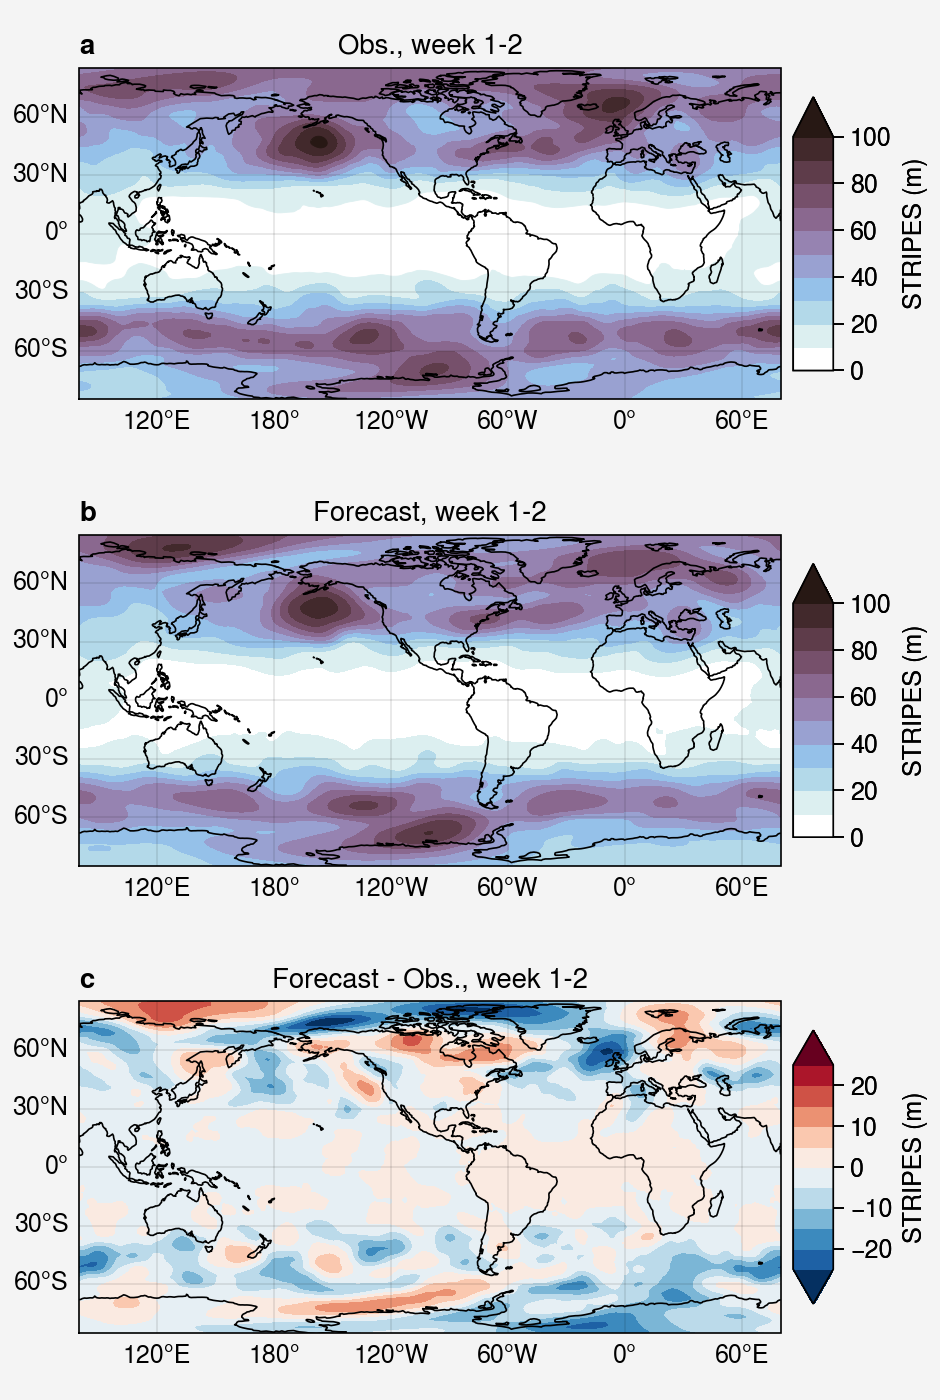

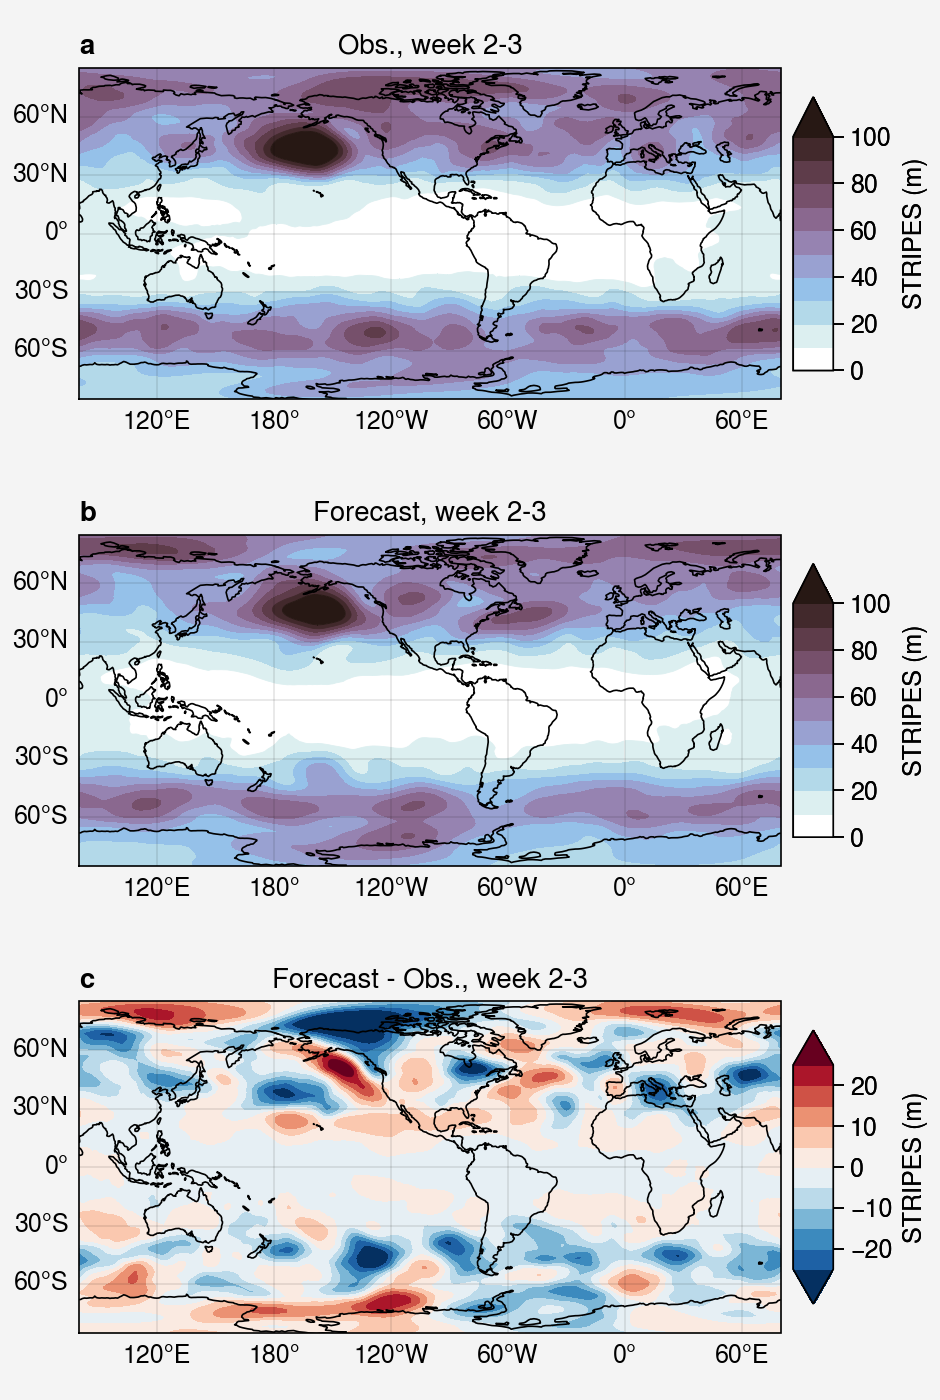

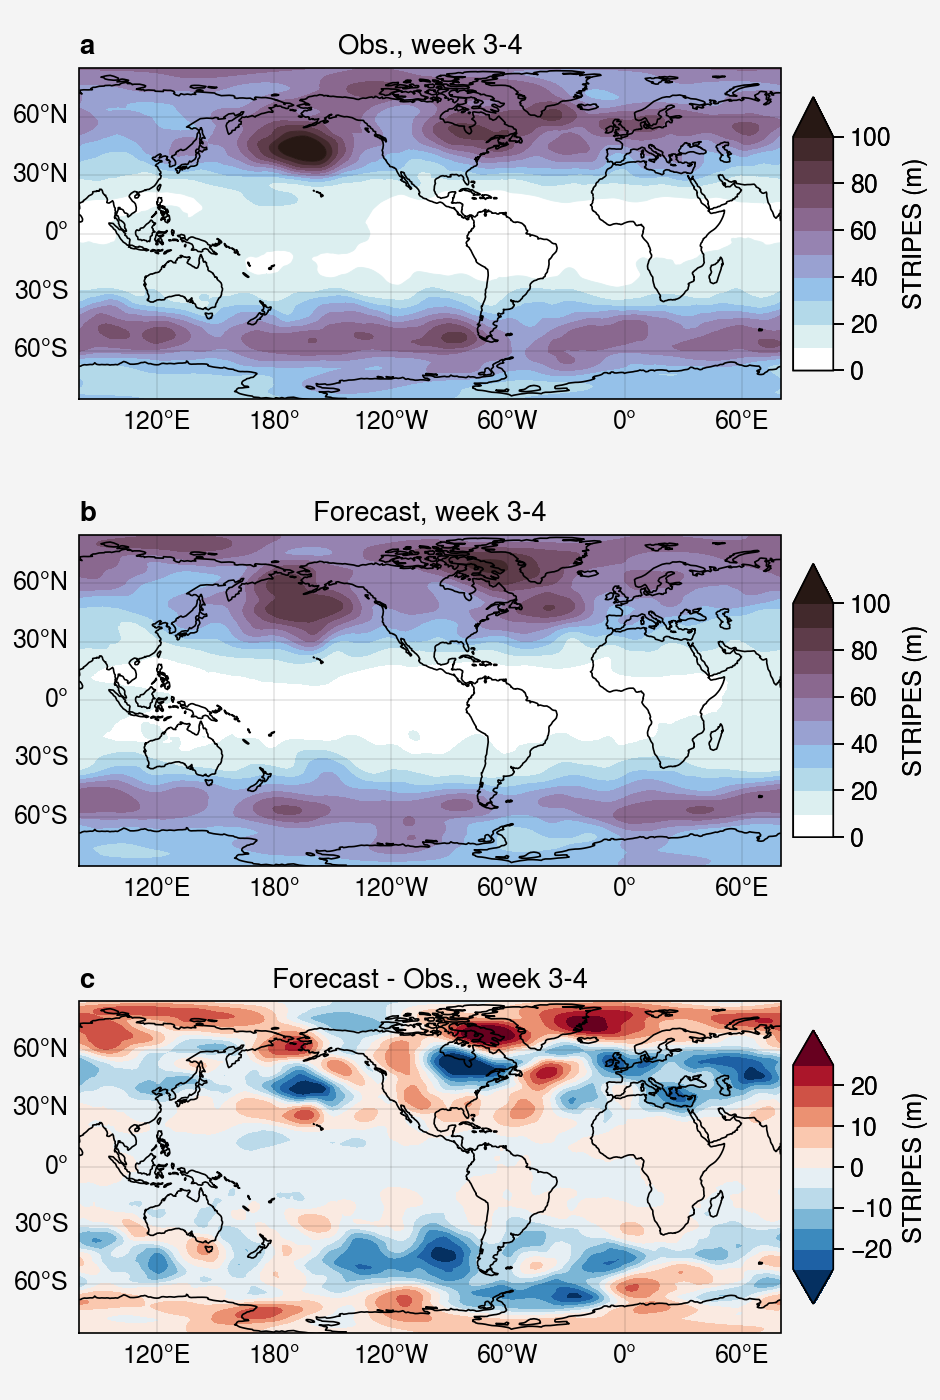

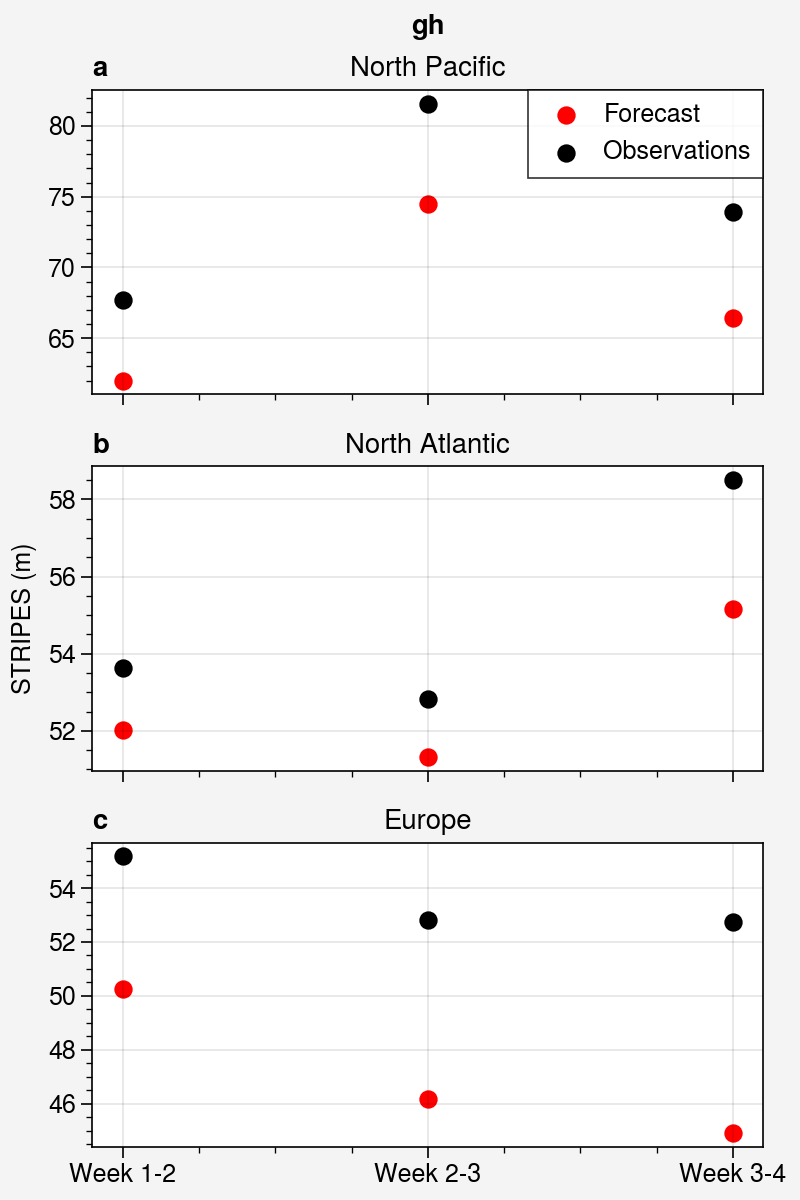

In [5]:
''' main code is here '''

if compSTRIPES_z500:
    makeSTRIPESfigs(Z500_DIR, Z500_DIR_OBS, RMM_FILE, 'gh', START_DATE, END_DATE)
    
if compSTRIPES_prec:
    makeSTRIPESfigs(PREC_DIR, PREC_DIR_OBS, RMM_FILE, 'prate', START_DATE, END_DATE)